## Projekt SNUM
<ul>
 <li>Karolina Sztolcman 148394 </li>
  <li>Kacper Świderski 148110</li>
</ul>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras.datasets import cifar10  # Możesz również użyć innego zbioru danych
import cv2

In [34]:
# Załaduj dane
(train_images, _), (test_images, _) = cifar10.load_data()


train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
# Przygotuj dane
train_images_gray = tf.image.rgb_to_grayscale(train_images).numpy()
test_images_gray = tf.image.rgb_to_grayscale(test_images).numpy()


In [35]:
# Model Autoenkodera
def build_autoencoder(input_shape):
    model = models.Sequential()

    # Koder
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))

    # Dekoder
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

    return model

In [ ]:
# Skonfiguruj model
input_shape = train_images_gray.shape[1:]
autoencoder = build_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mse')

# Wytrenuj model
history = autoencoder.fit(train_images_gray, train_images, epochs=10, batch_size=128, shuffle=True, validation_data=(test_images_gray, test_images))

# Przetestuj model
decoded_images = autoencoder.predict(test_images_gray)


Epoch 1/10
391/391 [==============================] - 21s 52ms/step - loss: 0.0151 - val_loss: 0.0112
Epoch 2/10
391/391 [==============================] - 20s 51ms/step - loss: 0.0100 - val_loss: 0.0094
Epoch 3/10
391/391 [==============================] - 20s 51ms/step - loss: 0.0093 - val_loss: 0.0090
Epoch 4/10
391/391 [==============================] - 19s 50ms/step - loss: 0.0088 - val_loss: 0.0093
Epoch 5/10
391/391 [==============================] - 20s 50ms/step - loss: 0.0087 - val_loss: 0.0084
Epoch 6/10
391/391 [==============================] - 20s 50ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 7/10
391/391 [==============================] - 21s 54ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 8/10
391/391 [==============================] - 20s 51ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 9/10
391/391 [==============================] - 21s 55ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 10/10
313/313 [==============================] - 1s 3ms/step


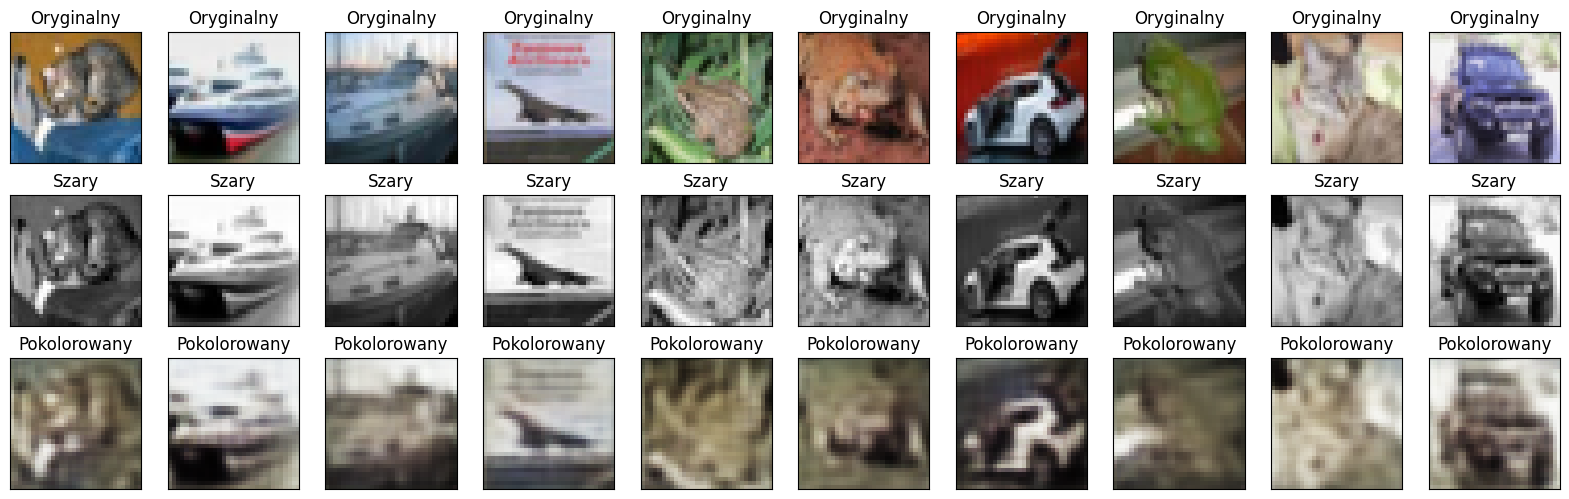

In [5]:
import matplotlib.pyplot as plt

n = 10  # liczba przykładów do wyświetlenia
plt.figure(figsize=(20, 6))

for i in range(n):
    # Wyświetl oryginalny obraz
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_images[i])
    plt.title("Oryginalny")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Wyświetl obraz w skali szarości przed dekodowaniem
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(test_images_gray[i][:, :, 0], cmap='gray')
    plt.title("Szary")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Wyświetl zdekodowany obraz
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_images[i])
    plt.title("Pokolorowany")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [15]:
def history_chart():
    plt.title('Strata modelu w trakcie epok treningu')
    plt.xlabel('Epoka')
    plt.ylabel('Strata')
    plt.plot(history.history['loss'], label='Strata treningowa')
    plt.plot(history.history['val_loss'], label='Strata walidacyjna')
    plt.xticks(np.arange(0, len(history.history['loss']), 1), np.arange(1, len(history.history['loss'])+1, 1))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

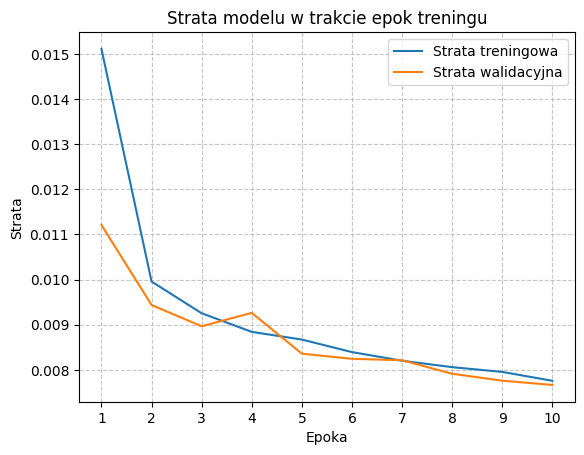

In [16]:
history_chart()

In [31]:
import cv2 as cv

def plot_disk_image(model, path, original_images, gray_images):
    # Wczytaj obraz z dysku
    y = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB).astype('float32') / 255
    x = cv.cvtColor(y, cv.COLOR_RGB2GRAY)

    # Przygotuj dane
    x = x.reshape(1, x.shape[0], x.shape[1], 1)

    # Przewiń obraz przez autoenkoder
    Y = model.predict(x)[0]

    # Wyświetl wyniki
    plt.figure(figsize=(8, 4))

    # Oryginalny obraz
    plt.subplot(1, 3, 1)
    plt.imshow(y)
    plt.title("Oryginalny")
    plt.gray()
    plt.axis('off')

    # Obraz w skali szarości przed dekodowaniem
    plt.subplot(1, 3, 2)
    plt.imshow(x[0, :, :, 0], cmap='gray')
    plt.title("Szary")
    plt.gray()
    plt.axis('off')

    # Zdekodowany obraz
    plt.subplot(1, 3, 3)
    plt.imshow(Y)
    plt.title("Pokolorowany")
    plt.gray()
    plt.axis('off')

    plt.show()

1/1 [==============================] - 0s 159ms/step


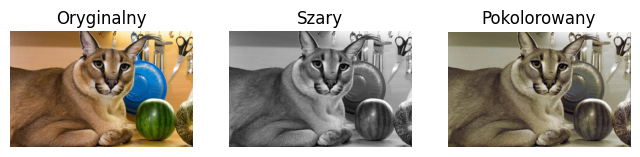

In [32]:
plot_disk_image(autoencoder, 'test.jpg', test_images, test_images_gray)